# Assignment 3: Colors and Word Models.

The following cells describe how to build a neural network that generates color names from RGB values.

We can give the neural network a list of paint colors (14157) along with their RGB values. (RGB = red, green, and blue color values).

Could the neural network learn to invent new paint colors and give them "meaningful" names?

In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas

np.random.seed(10)
print (tf.__version__)

2.3.0


In [2]:
import io
import requests
url="https://raw.githubusercontent.com/Tony607/Keras-Colors/master/colors.csv"
s=requests.get(url).content
data=pandas.read_csv(io.StringIO(s.decode('utf-8')))
data.head(20)

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130
5,light urple,179,111,246
6,east side,172,145,206
7,florida seashells,250,228,199
8,paris,145,167,189
9,powder blush,247,215,215


In [3]:
len(data)

14157

In [4]:
names = data["name"]

## Tokenize, char level

We will consider that every color name is a sequences of characters (max=25).

In [5]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

## One-hot encoding

We use a one-hot estrategy to encode characters.

In [6]:
from keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)
num_classes = one_hot_names.shape[-1]
num_classes

28

In [7]:
one_hot_names.shape

(14157, 25, 28)

In [8]:
t.word_index

{'e': 1,
 'a': 2,
 'r': 3,
 ' ': 4,
 'i': 5,
 'n': 6,
 'l': 7,
 'o': 8,
 't': 9,
 's': 10,
 'c': 11,
 'u': 12,
 'd': 13,
 'g': 14,
 'p': 15,
 'h': 16,
 'm': 17,
 'b': 18,
 'y': 19,
 'w': 20,
 'k': 21,
 'f': 22,
 'v': 23,
 'z': 24,
 'q': 25,
 'j': 26,
 'x': 27}

In [9]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])


Now we build a LSTM model that reads sequences of characters and produces a scaled-RGB triplet as output. This is a many-to-one sequential model. 

In [10]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 256)           291840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 505,859
Trainable params: 505,859
Non-trainable params: 0
_________________________________________________________________


We train the model with our dataset.

In [11]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/40
399/399 [==============================] - 57s 143ms/step - loss: 0.0601 - acc: 0.6313 - val_loss: 0.0611 - val_acc: 0.6688
Epoch 2/40
131/399 [========>.....................] - ETA: 33s - loss: 0.0560 - acc: 0.6634

KeyboardInterrupt: 

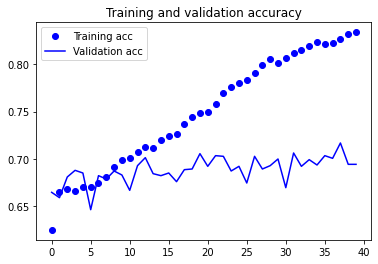

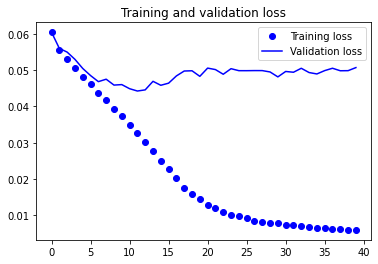

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Now we are ready to predict color of a random name:

In [ ]:
# Plot a color image.
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [ ]:
def scale(n):
    return int(n * 255) 

In [ ]:
def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

In [ ]:
model.save("modelFlipped.h5")

light blue, R,G,B: 156 214 243


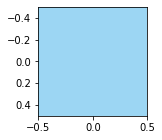

blue, R,G,B: 8 38 213


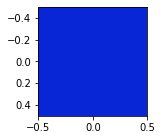

dark blue, R,G,B: 10 17 117


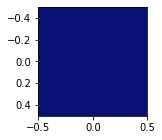

In [ ]:
predict("light blue")
predict("blue")
predict("dark blue")

black, R,G,B: 28 26 39


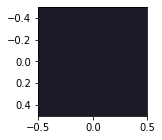

white, R,G,B: 244 241 238


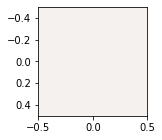

In [ ]:
predict("black")
predict("white")

tensorflow orange, R,G,B: 236 130 63


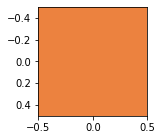

forest, R,G,B: 33 73 43


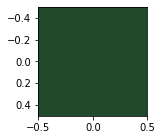

evergreen, R,G,B: 23 64 39


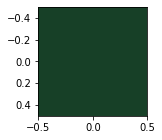

tangerine, R,G,B: 250 106 21


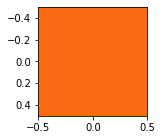

In [ ]:
predict("tensorflow orange")
predict("forest")
predict("evergreen")
predict("tangerine")

princess ivory, R,G,B: 219 220 194


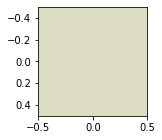

In [ ]:
predict("princess ivory")

bull cream, R,G,B: 231 236 205


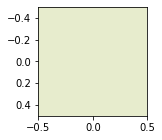

In [ ]:
predict("bull cream")

keras red, R,G,B: 192 31 49


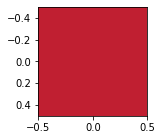

In [ ]:
predict("keras red")

tensorflow orange, R,G,B: 236 130 63


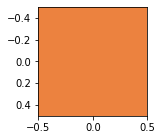

forest, R,G,B: 33 73 43


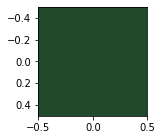

bull cream, R,G,B: 231 236 205


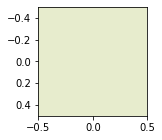

keras red, R,G,B: 192 31 49


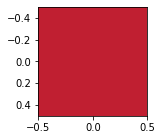

In [ ]:
predict("tensorflow orange")
predict("forest")
predict("bull cream")
predict("keras red")

## Questions and Exercises

1. We got, with the current model, a `val_acc = 0.6942` when training the model. Explore different strategies to train the model in order to get better results. Some ideas (no guarantee!):
    + You can train the model using character bigrams (such as `aa`, `ab`, ..., `zz`), or even trigrams, instead of characters. This should produce a more powerful model, but the devil is in the details. For example, some bigrams cannot be present in the training set but they might be in the training set. If we want to build a generic model we should consider any possible bigram.
    + You can use an embedding layer to represents bigrams or trigrams.
    + You can use bidirectional LSTM to learn sequences.
    + Etc.

2. Design and train a model to predict words from color. That is, your input will be a RGB triplet and your outputs a string. This is a one-to-many sequence model. This problem is harder than the previous one...

# Report

Please, answer the following questions (and include in this notebook all code necessary to suport your answers):

1. Which is the best model you have build? (architecture, word representations, etc.)
2. Report, in terms of accuracy, the best model you got to predict words from colors. Show examples. 
